# Project: Wrangling and Analyze Data

In [1]:
# Import the libraries that we will need in this project
import pandas as pd
import datetime as dt
import numpy as np
import requests
import tweepy
import json
import configparser
import re
import datetime
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
# Read the twitter-archive-enhanced.csv file and store it as dataframe in archive
archive = pd.read_csv('twitter-archive-enhanced.csv', encoding = 'utf-8')
# Quick check to the file content and structure
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# Using Requests library to download a file then store it in a tsv file

url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response=requests.get(url)

with open(url.split("/")[-1], 'wb') as file:
    file.write(response.content)
    
# Read the downloaded file into a dataframe 'images'
images = pd.read_csv('image-predictions.tsv', sep = '\t', encoding = 'utf-8')
               
# Quick check to the file content and structure
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
# Access credentials file and refer the twitter developer credentials 
config=configparser.ConfigParser()
config.read("config.ini")
api_key=config['twitter']['api_key']
api_key_secret=config['twitter']['api_key_secret']
access_token=config['twitter']['access_token']
access_token_secret=config['twitter']['access_token_secret']

auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api=tweepy.API(auth, 
               parser = tweepy.parsers.JSONParser(), # Parse the result to Json Object
               wait_on_rate_limit = True, # Automatically wait for rate limits to replenish
               wait_on_rate_limit_notify = True 
               )

In [5]:
# Liste where we will store the dictionaries of our result
df_list = []
# Liste frame where we will store the tweet_id of the errors
error_list = []

# Calculate the time of excution
start = timer()

# Get the tweet object for all the teweets in archive dataframe 
for tweet_id in archive['tweet_id']:
    try:
        page = api.get_status(tweet_id, tweet_mode = 'extended')
        # Print one page to look at the structure of the returned file
        # and the names of attributes
        # print(json.dumps(page, indent = 4))
        #break
        
        favorites = page['favorite_count'] # How many favorites the tweet had
        user_followers = page['user']['followers_count'] # How many followers the user had
        user_favourites = page['user']['favourites_count'] # How many favorites the user had
        date_time = page['created_at'] # The date and time of the creation
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
    
    # Catch the exceptions of the TweepError
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        error_list.append(tweet_id)

# Calculate the time of excution
end = timer()
print(end - start)


888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 _ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 _ [{'code': 144, 'message': 'No status found with that ID.'}]
856330835276025856 _ [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560 _ [{'code': 144, 'message': 'No status found with that ID.'}]
851861385021730816 _ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 _ [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 _ [{'code

In [6]:
#The lengh of the result
len(df_list)

2327

In [7]:
#The lengh of the error
len(error_list)

29

From the above results:

- We reached the limit of the tweepy API twice but wait_on_rate_limit automatically wait for rate limits to replenish and wait_on_rate_limit_notify print a notification when Tweepy is waiting
- The total time was about 1907 seconds (~ 31 min)
- We could get 2356 tweet_id correctly. With 29 errors (we will query those 29 errors separately)

In [8]:
# We repeat the same operation for the tweet_ids that we coudln't get and append the result to df_list
e_list = []
for e in error_list:
    try:
        favorites = page['favorite_count']       
        user_followers = page['user']['followers_count']
        user_favourites = page['user']['favourites_count']
        date_time = page['created_at']
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),                        
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
        
    except Exception:
        print(str(tweet_id)+ " _ " + str(e))
        e_list.append(e)

In [9]:
#The lengh of the result after Querying the errors separately
#We can see that now the 29 errors saved in the list
len(df_list)

2356

In [10]:
# Create DataFrames from list of dictionaries
columns = ['tweet_id', 'favorites', 'user_followers', 'user_favourites', 'date_time']
json_df = pd.DataFrame(df_list, columns=columns)

# Save the dataFrame in file
json_df.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [11]:
# Read the saved tweet_json.txt file into a dataframe
json_df = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
json_df.head()

,tweet_id,favorites,user_followers,user_favourites,date_time
0,892420643555336193,33744,9326887,147183,2017-08-01 16:23:56
1,892177421306343426,29274,9326887,147183,2017-08-01 00:17:27
2,891815181378084864,22003,9326887,147183,2017-07-31 00:18:03
3,891689557279858688,36856,9326887,147183,2017-07-30 15:58:51
4,891327558926688256,35235,9326887,147183,2017-07-29 16:00:24


## Assessing Data


> ### Visual assessment

In [12]:
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [13]:
images

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [14]:
json_df

,tweet_id,favorites,user_followers,user_favourites,date_time
0,892420643555336193,33744,9326887,147183,2017-08-01 16:23:56
1,892177421306343426,29274,9326887,147183,2017-08-01 00:17:27
2,891815181378084864,22003,9326887,147183,2017-07-31 00:18:03
3,891689557279858688,36856,9326887,147183,2017-07-30 15:58:51
4,891327558926688256,35235,9326887,147183,2017-07-29 16:00:24
5,891087950875897856,17771,9326887,147183,2017-07-29 00:08:17
6,890971913173991426,10350,9326887,147183,2017-07-28 16:27:12
7,890729181411237888,56734,9326887,147183,2017-07-28 00:22:40
8,890609185150312448,24466,9326887,147183,2017-07-27 16:25:51
9,890240255349198849,27889,9326887,147183,2017-07-26 15:59:51


> ### programatic assessment

In [15]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
# Check if duplicated entries
archive[archive.duplicated(keep=False)==True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [17]:
# Check denominators different from 10 and understand why. 
archive.query('rating_denominator != 10')[['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
313,960,0
342,11,15
433,84,70
516,24,7
784,9,11
902,165,150
1068,9,11
1120,204,170
1165,4,20
1202,50,50


In [18]:
archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [19]:
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [20]:
# Check the outliers
archive.query('rating_numerator == [1776, 960, 666, 420, 182]')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,194351775.0,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,13615722.0,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,21955058.0,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670842764...,420,10,None,None,None,None,None


In [21]:
# count number of invalid name
archive.query('name==["None", "a", "an",  "my", "by"]')['name'].count()

809

In [22]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
# Check duplicated entries
images[images.duplicated(keep=False)==True]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [24]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 5 columns):
tweet_id           2356 non-null int64
favorites          2356 non-null int64
user_followers     2356 non-null int64
user_favourites    2356 non-null int64
date_time          2356 non-null object
dtypes: int64(4), object(1)
memory usage: 92.1+ KB


In [25]:
json_df[json_df.duplicated(keep=False)==True].shape

(30, 5)

### Quality issues

##### archive dataset

- 1. The columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp have over 2200 null values.


- 2. The source column is in HTML instead of having just a URL.


- 3. The date_time column is type Object instead of datetime64 and time and date elements are all in the same column.


- 4. doggo,	floofer, pupper, puppo, contains value None instead of NaN.


- 5. The name column has invalid values a, an, None


- 6. invalid rating_denominator 0 and different from 10


- 7. Keeping just date in date_time column will help


##### json_df dataset


- 8. There are 30 duplicates entries in json_df.


### Tidiness issues

##### archive dataset

- 1. Various stages of dogs in columns instead of rows.


##### images dataset

- 2. No need of all the informations in images dataset tweet_id and jpg_url matter and one column for breed.


- 3. timestamp column is useless since we already have datetime column


## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [26]:
# Make copies of original pieces of data
# Since we want to create one high quality and tidy master pandas DataFrame
# we will start by merging our dataframe in one
# then we save the result in file as backup
master_df = pd.merge(archive, images, how = 'left', on = ['tweet_id'] )
master_df = pd.merge(master_df, json_df, how = 'left', on = ['tweet_id'])
master_df.to_csv('master_df.csv', encoding = 'utf-8')
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 32 columns):
tweet_id                      2385 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2385 non-null object
source                        2385 non-null object
text                          2385 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2326 non-null object
rating_numerator              2385 non-null int64
rating_denominator            2385 non-null int64
name                          2385 non-null object
doggo                         2385 non-null object
floofer                       2385 non-null object
pupper                        2385 non-null object
puppo                         2385 non-null object
jpg_url                       21

### Cleaning quality Issue #1: 

#### Define: 
 We  remove the columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp because they are populated by over 80%  null values and also we are not interested in . 


#### Code

In [27]:
master_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [28]:
master_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorites,user_followers,user_favourites,date_time
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,...,bagel,0.085851,False,banana,0.076110,False,33744.0,9326887.0,147183.0,2017-08-01 16:23:56
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,...,Pekinese,0.090647,True,papillon,0.068957,True,29274.0,9326887.0,147183.0,2017-08-01 00:17:27
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,...,malamute,0.078253,True,kelpie,0.031379,True,22003.0,9326887.0,147183.0,2017-07-31 00:18:03
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,...,Labrador_retriever,0.168086,True,spatula,0.040836,False,36856.0,9326887.0,147183.0,2017-07-30 15:58:51
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,...,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,35235.0,9326887.0,147183.0,2017-07-29 16:00:24


### Cleaning quality Issue #2:

#### The source column is in HTML code instead of having just a URL


#### Code

In [29]:
master_df.source=master_df.source.map(lambda x: re.split('["]', x)[1])

#### Test

In [30]:
master_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorites,user_followers,user_favourites,date_time
0,892420643555336193,2017-08-01 16:23:56 +0000,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,...,bagel,0.085851,False,banana,0.076110,False,33744.0,9326887.0,147183.0,2017-08-01 16:23:56
1,892177421306343426,2017-08-01 00:17:27 +0000,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,...,Pekinese,0.090647,True,papillon,0.068957,True,29274.0,9326887.0,147183.0,2017-08-01 00:17:27
2,891815181378084864,2017-07-31 00:18:03 +0000,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,...,malamute,0.078253,True,kelpie,0.031379,True,22003.0,9326887.0,147183.0,2017-07-31 00:18:03
3,891689557279858688,2017-07-30 15:58:51 +0000,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,...,Labrador_retriever,0.168086,True,spatula,0.040836,False,36856.0,9326887.0,147183.0,2017-07-30 15:58:51
4,891327558926688256,2017-07-29 16:00:24 +0000,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,...,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,35235.0,9326887.0,147183.0,2017-07-29 16:00:24


### Cleaning quality Issue #3: 

####  Change the date_time column  type to  datetime64 and create day, month, and year column

#### Code 

In [31]:
master_df.date_time=pd.to_datetime(master_df.date_time)
master_df['day']=master_df['date_time'].dt.strftime('%d')
master_df['month']=master_df['date_time'].dt.strftime('%m')
master_df['year']=master_df['date_time'].dt.strftime('%Y')

#### Test

In [32]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 30 columns):
tweet_id              2385 non-null int64
timestamp             2385 non-null object
source                2385 non-null object
text                  2385 non-null object
expanded_urls         2326 non-null object
rating_numerator      2385 non-null int64
rating_denominator    2385 non-null int64
name                  2385 non-null object
doggo                 2385 non-null object
floofer               2385 non-null object
pupper                2385 non-null object
puppo                 2385 non-null object
jpg_url               2104 non-null object
img_num               2104 non-null float64
p1                    2104 non-null object
p1_conf               2104 non-null float64
p1_dog                2104 non-null object
p2                    2104 non-null object
p2_conf               2104 non-null float64
p2_dog                2104 non-null object
p3                    2104 non-nu

### Cleaning quality Issue #4:

#### Replace None by Null in doggo, floofer, pupper, puppo columns

#### Code

In [33]:
for stage in ['doggo','floofer','pupper','puppo']:
    master_df[stage].replace( 'None', np.nan, inplace=True)


#### Test

In [34]:
master_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p3,p3_conf,p3_dog,favorites,user_followers,user_favourites,date_time,day,month,year
0,892420643555336193,2017-08-01 16:23:56 +0000,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,...,banana,0.076110,False,33744.0,9326887.0,147183.0,2017-08-01 16:23:56,01,08,2017
1,892177421306343426,2017-08-01 00:17:27 +0000,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,...,papillon,0.068957,True,29274.0,9326887.0,147183.0,2017-08-01 00:17:27,01,08,2017
2,891815181378084864,2017-07-31 00:18:03 +0000,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,...,kelpie,0.031379,True,22003.0,9326887.0,147183.0,2017-07-31 00:18:03,31,07,2017
3,891689557279858688,2017-07-30 15:58:51 +0000,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,...,spatula,0.040836,False,36856.0,9326887.0,147183.0,2017-07-30 15:58:51,30,07,2017
4,891327558926688256,2017-07-29 16:00:24 +0000,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,...,German_short-haired_pointer,0.175219,True,35235.0,9326887.0,147183.0,2017-07-29 16:00:24,29,07,2017


### Cleaning quality Issue #5:

####  Replacement of all invalid names containing less than two characters by None 

#### Code

In [35]:
name_to_remove=["None", "a", "an",  "my", "by", "O"]
        
for name in name_to_remove:
    if name=="O":
        master_df['name'].replace(name, "O'Malley", inplace=True)
    elif name=="my":
        master_df['name'].replace(name, "Zoey", inplace=True)
    else:
        master_df['name'].replace(name, "None", inplace=True)
   

#### Test

In [36]:
master_df['name']

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
5           None
6            Jax
7           None
8           Zoey
9         Cassie
10          Koda
11         Bruno
12          None
13           Ted
14        Stuart
15        Oliver
16           Jim
17          Zeke
18       Ralphus
19        Canela
20        Gerald
21       Jeffrey
22          such
23        Canela
24          None
25          None
26          Maya
27        Mingus
28         Derek
29        Roscoe
          ...   
2355        None
2356        None
2357        None
2358        None
2359        None
2360        None
2361        None
2362        None
2363        None
2364        None
2365        None
2366        None
2367        None
2368        None
2369        None
2370        None
2371        None
2372        None
2373        None
2374        None
2375        None
2376        None
2377        None
2378        None
2379        None
2380        None
2381        None
2382        No

### Cleaning quality Issue #6:

#### Correct the rating_numerator and  rating_denominator columns

#### Code

In [37]:
zero=0
master_df['rating_denominator'].replace(zero, np.nan , inplace=True)

master_df['rating_numerator'].replace(zero, np.nan , inplace=True)
       
#CODE: Create a new column with rating in float type to avoid converting all int column to float
master_df['rating'] = 10 * master_df['rating_numerator'] / master_df['rating_denominator'].astype(float)


#### Test

In [38]:
master_df.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p3_conf,p3_dog,favorites,user_followers,user_favourites,date_time,day,month,year,rating
1508,691483041324204033,2016-01-25 04:49:38 +0000,http://twitter.com/download/iphone,When bae says they can't go out but you see th...,https://twitter.com/dog_rates/status/691483041...,5.0,10.0,None,NaN,NaN,...,0.009826,True,2199.0,9326889.0,147183.0,2016-01-25 04:49:38,25,01,2016,5.0
130,867072653475098625,2017-05-23 17:40:04 +0000,http://twitter.com/download/iphone,RT @rachaeleasler: these @dog_rates hats are 1...,https://twitter.com/rachaeleasler/status/86501...,13.0,10.0,None,NaN,NaN,...,0.112952,True,0.0,9326887.0,147183.0,2017-05-23 17:40:04,23,05,2017,13.0
1209,715696743237730304,2016-04-01 00:26:15 +0000,http://twitter.com/download/iphone,Meet Toby. He's a Lithuanian High-Steppin Stic...,https://twitter.com/dog_rates/status/715696743...,10.0,10.0,Toby,NaN,NaN,...,0.132135,True,3610.0,9326889.0,147183.0,2016-04-01 00:26:15,01,04,2016,10.0
467,817120970343411712,2017-01-05 21:29:55 +0000,http://twitter.com/download/iphone,Name a more iconic quartet... I'll wait. 13/10...,https://twitter.com/dog_rates/status/817120970...,13.0,10.0,None,NaN,NaN,...,0.157130,True,11529.0,9326886.0,147183.0,2017-01-05 21:29:55,05,01,2017,13.0
1088,737826014890496000,2016-06-01 02:00:04 +0000,http://twitter.com/download/iphone,This is Remy. He has some long ass ears (proba...,https://twitter.com/dog_rates/status/737826014...,10.0,10.0,Remy,NaN,NaN,...,0.002869,True,4830.0,9326889.0,147183.0,2016-06-01 02:00:04,01,06,2016,10.0


### Cleaning quality Issue #7:

#### Replacement of a the five outliers in the rating_numerator column by NaN

#### Code

In [39]:
# Replace outliers in rating column by NaN
for outlier in [1776, 960, 666, 420, 182]:
    master_df['rating'].replace(outlier, np.nan, inplace=True)
    

#### Test

In [40]:
# Check for unique rating_numerator values after cleaining outliers
master_df['rating'].unique()

array([ 13.        ,  12.        ,  14.        ,   5.        ,
        17.        ,  11.        ,  10.        ,          nan,
         6.        ,  15.        ,  75.        ,   7.33333333,
         7.        ,   9.        ,  34.28571429,   8.        ,
         1.        ,  27.        ,   3.        ,   8.18181818,
         4.        ,   2.        ,   6.36363636,  12.5       ,  26.        ])

### Cleaning quality Issue #8:

#### Define Drop 30 duplicates entries in json_df.

#### Code

In [41]:
master_df.drop_duplicates(inplace=True)

#### Test

In [42]:
# We see that 30 duplicates have been dropped
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2354 non-null float64
rating_denominator    2355 non-null float64
name                  2356 non-null object
doggo                 97 non-null object
floofer               10 non-null object
pupper                257 non-null object
puppo                 30 non-null object
jpg_url               2075 non-null object
img_num               2075 non-null float64
p1                    2075 non-null object
p1_conf               2075 non-null float64
p1_dog                2075 non-null object
p2                    2075 non-null object
p2_conf               2075 non-null float64
p2_dog                2075 non-null object
p3                    2075 non-null 

### Cleaning untidiness Issue #1:

#### Define  Various stages of dogs in columns instead of rows.

#### Code

In [43]:
master_df_clean = master_df.melt(id_vars=['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog',
       'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorites', 'user_followers', 'user_favourites',
       'date_time', 'day', 'month', 'year', 'rating'], 
                                 var_name='stage', value_name='stage_value')


#### Test

In [44]:
master_df_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,favorites,user_followers,user_favourites,date_time,day,month,year,rating,stage,stage_value
0,892420643555336193,2017-08-01 16:23:56 +0000,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,...,33744.0,9326887.0,147183.0,2017-08-01 16:23:56,01,08,2017,13.0,doggo,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,...,29274.0,9326887.0,147183.0,2017-08-01 00:17:27,01,08,2017,13.0,doggo,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,...,22003.0,9326887.0,147183.0,2017-07-31 00:18:03,31,07,2017,12.0,doggo,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,...,36856.0,9326887.0,147183.0,2017-07-30 15:58:51,30,07,2017,13.0,doggo,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,...,35235.0,9326887.0,147183.0,2017-07-29 16:00:24,29,07,2017,12.0,doggo,NaN
5,891087950875897856,2017-07-29 00:08:17 +0000,http://twitter.com/download/iphone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,...,17771.0,9326887.0,147183.0,2017-07-29 00:08:17,29,07,2017,13.0,doggo,NaN
6,890971913173991426,2017-07-28 16:27:12 +0000,http://twitter.com/download/iphone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10.0,Jax,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1.0,...,10350.0,9326887.0,147183.0,2017-07-28 16:27:12,28,07,2017,13.0,doggo,NaN
7,890729181411237888,2017-07-28 00:22:40 +0000,http://twitter.com/download/iphone,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13.0,10.0,None,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2.0,...,56734.0,9326887.0,147183.0,2017-07-28 00:22:40,28,07,2017,13.0,doggo,NaN
8,890609185150312448,2017-07-27 16:25:51 +0000,http://twitter.com/download/iphone,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13.0,10.0,Zoey,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1.0,...,24466.0,9326887.0,147183.0,2017-07-27 16:25:51,27,07,2017,13.0,doggo,NaN
9,890240255349198849,2017-07-26 15:59:51 +0000,http://twitter.com/download/iphone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14.0,10.0,Cassie,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1.0,...,27889.0,9326887.0,147183.0,2017-07-26 15:59:51,26,07,2017,14.0,doggo,doggo


### Cleaning untidiness Issue #2:

##### Define  Create one column for image prediction and one column for confidence level

##### Code

In [45]:
#CODE: the first true prediction (p1, p2 or p3) will be store in these lists
breed = []
confidence_list = []

#create a function with nested if to capture the dog type and confidence level
# from the first 'true' prediction
def image(images_df):
    if images_df['p1_dog'] == True:
        breed.append(images_df['p1'])
        confidence_list.append(images_df['p1_conf'])
    elif images_df['p2_dog'] == True:
        breed.append(images_df['p2'])
        confidence_list.append(images_df['p2_conf'])
    elif images_df['p3_dog'] == True:
        breed.append(images_df['p3'])
        confidence_list.append(images_df['p3_conf'])
    else:
        breed.append(np.nan)
        confidence_list.append(np.nan)

#series objects having index the image_prediction_clean column.        
master_df_clean.apply(image, axis=1)

#create new columns
master_df_clean['breed'] = breed
master_df_clean['confidence'] = confidence_list

##### Test

In [46]:
master_df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,user_favourites,date_time,day,month,year,rating,stage,stage_value,breed,confidence
0,892420643555336193,2017-08-01 16:23:56 +0000,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,...,147183.0,2017-08-01 16:23:56,01,08,2017,13.0,doggo,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,...,147183.0,2017-08-01 00:17:27,01,08,2017,13.0,doggo,NaN,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03 +0000,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,...,147183.0,2017-07-31 00:18:03,31,07,2017,12.0,doggo,NaN,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51 +0000,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,...,147183.0,2017-07-30 15:58:51,30,07,2017,13.0,doggo,NaN,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24 +0000,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,...,147183.0,2017-07-29 16:00:24,29,07,2017,12.0,doggo,NaN,basset,0.555712


### Cleaning untidiness Issue #3:

#### Remove all other columns from images dataset except tweet_id and jpg_url

#### Code

In [47]:
master_df_clean.drop(['timestamp','rating_numerator', 'rating_denominator', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)

#### Test

In [48]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 19 columns):
tweet_id           9424 non-null int64
source             9424 non-null object
text               9424 non-null object
expanded_urls      9188 non-null object
name               9424 non-null object
jpg_url            8300 non-null object
img_num            8300 non-null float64
favorites          9308 non-null float64
user_followers     9308 non-null float64
user_favourites    9308 non-null float64
date_time          9308 non-null datetime64[ns]
day                9424 non-null object
month              9424 non-null object
year               9424 non-null object
rating             9392 non-null float64
stage              9424 non-null object
stage_value        394 non-null object
breed              7004 non-null object
confidence         7004 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(11)
memory usage: 1.4+ MB


## Iterate quality cleaning

###

####  Now let's remove all row containing NaN value from our master_df_clean dataframe

#### code

In [49]:
# remove nulls by rows
master_df_clean.dropna(axis=0, inplace=True)

In [50]:
# reset the index of the new dataframe
master_df_clean.reset_index(drop=True, inplace=True)

In [51]:
# drop stage_value column
master_df_clean.drop('stage_value', axis=1, inplace=True)

#### Test

In [52]:
master_df_clean

,tweet_id,source,text,expanded_urls,name,jpg_url,img_num,favorites,user_followers,user_favourites,date_time,day,month,year,rating,stage,breed,confidence
0,890240255349198849,http://twitter.com/download/iphone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,Cassie,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1.0,27889.0,9326887.0,147183.0,2017-07-26 15:59:51,26,07,2017,14.0,doggo,Pembroke,0.511319
1,884162670584377345,http://twitter.com/download/iphone,Meet Yogi. He doesn't have any important dog m...,https://twitter.com/dog_rates/status/884162670...,Yogi,https://pbs.twimg.com/media/DEUtQbzW0AUTv_o.jpg,1.0,17914.0,9326887.0,147183.0,2017-07-09 21:29:42,09,07,2017,12.0,doggo,German_shepherd,0.707046
2,872967104147763200,http://twitter.com/download/iphone,Here's a very large dog. He has a date later. ...,https://twitter.com/dog_rates/status/872967104...,None,https://pbs.twimg.com/media/DB1m871XUAAw5vZ.jpg,2.0,24021.0,9326887.0,147183.0,2017-06-09 00:02:31,09,06,2017,12.0,doggo,Labrador_retriever,0.476913
3,871515927908634625,http://twitter.com/download/iphone,This is Napolean. He's a Raggedy East Nicaragu...,https://twitter.com/dog_rates/status/871515927...,Napolean,https://pbs.twimg.com/media/DBg_HT9WAAEeIMM.jpg,2.0,17865.0,9326887.0,147183.0,2017-06-04 23:56:03,04,06,2017,12.0,doggo,komondor,0.974781
4,869596645499047938,http://twitter.com/download/iphone,This is Scout. He just graduated. Officially a...,https://twitter.com/dog_rates/status/869596645...,Scout,https://pbs.twimg.com/media/DBFtiYqWAAAsjj1.jpg,1.0,14166.0,9326887.0,147183.0,2017-05-30 16:49:31,30,05,2017,12.0,doggo,Chihuahua,0.955156
5,858843525470990336,http://twitter.com/download/iphone,I have stumbled puppon a doggo painting party....,https://twitter.com/dog_rates/status/858843525...,None,https://pbs.twimg.com/media/C-s5oYZXkAAMHHq.jpg,1.0,14102.0,9326887.0,147183.0,2017-05-01 00:40:27,01,05,2017,13.0,doggo,golden_retriever,0.578120
6,855851453814013952,http://twitter.com/download/iphone,Here's a puppo participating in the #ScienceMa...,https://twitter.com/dog_rates/status/855851453...,None,https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg,1.0,41859.0,9326887.0,147183.0,2017-04-22 18:31:02,22,04,2017,13.0,doggo,flat-coated_retriever,0.321676
7,854010172552949760,http://twitter.com/download/iphone,"At first I thought this was a shy doggo, but i...",https://twitter.com/dog_rates/status/854010172...,None,https://pbs.twimg.com/media/C9oNt91WAAAFSLS.jpg,1.0,14820.0,9326887.0,147183.0,2017-04-17 16:34:26,17,04,2017,11.0,doggo,English_springer,0.354733
8,846514051647705089,http://twitter.com/download/iphone,This is Barney. He's an elder doggo. Hitches a...,https://twitter.com/dog_rates/status/846514051...,Barney,https://pbs.twimg.com/media/C79sB4xXwAEvwKY.jpg,2.0,41152.0,9326887.0,147183.0,2017-03-28 00:07:32,28,03,2017,13.0,doggo,golden_retriever,0.650003
9,845397057150107648,http://twitter.com/download/iphone,Say hello to Mimosa. She's an emotional suppor...,"https://www.gofundme.com/help-save-a-pup,https...",Mimosa,https://pbs.twimg.com/media/C7t0IzLWkAINoft.jpg,1.0,7083.0,9326887.0,147183.0,2017-03-24 22:08:59,24,03,2017,13.0,doggo,Dandie_Dinmont,0.394404


### Now let's change the  img_num, favorites, user_followers, user_favorites to integer and breed column type to category

#### code

In [53]:
cols=['img_num', 'favorites', 'user_followers', 'user_favourites']
for col in cols:
    master_df_clean[col]=master_df_clean[col].astype('int')
    
master_df_clean['breed']=master_df_clean['breed'].astype('category')

#### Test

In [54]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 18 columns):
tweet_id           280 non-null int64
source             280 non-null object
text               280 non-null object
expanded_urls      280 non-null object
name               280 non-null object
jpg_url            280 non-null object
img_num            280 non-null int64
favorites          280 non-null int64
user_followers     280 non-null int64
user_favourites    280 non-null int64
date_time          280 non-null datetime64[ns]
day                280 non-null object
month              280 non-null object
year               280 non-null object
rating             280 non-null float64
stage              280 non-null object
breed              280 non-null category
confidence         280 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(5), object(9)
memory usage: 40.7+ KB


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [55]:
# write master_df_clean to csv file
master_df_clean.to_csv('twitter_archive_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [56]:
twitter_archive_master = master_df_clean

### Visualization #1: number of tweets per breed

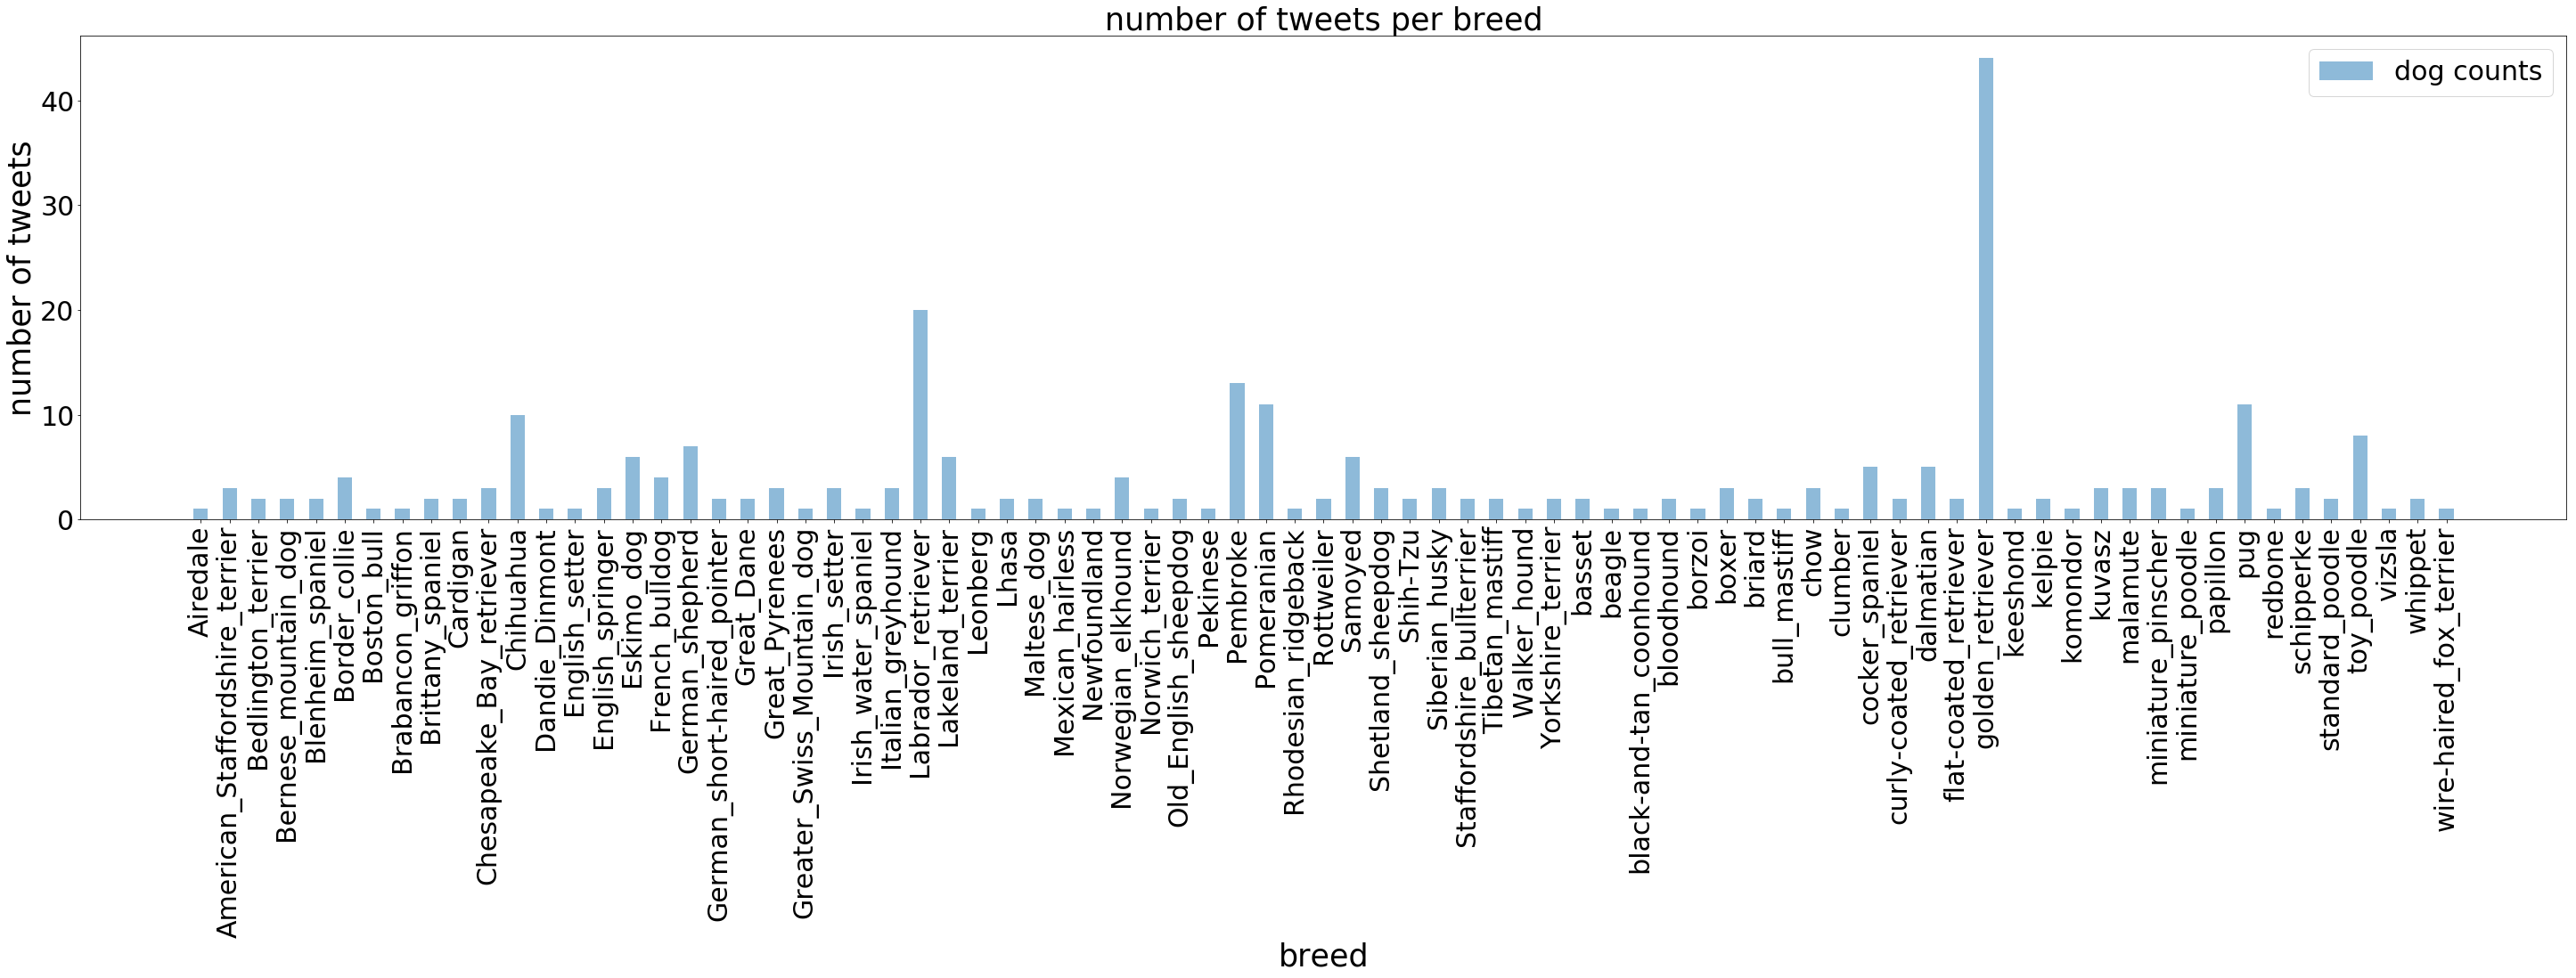

In [57]:
y=list(twitter_archive_master.breed.value_counts().values)
x=list(twitter_archive_master.breed.value_counts().index)

fig, ax=plt.subplots(figsize=(50, 10))

ax.bar(x, y, label='dog counts', width=0.5, align='center', alpha=0.5)

plt.xlabel('breed', fontsize=35)
plt.ylabel('number of tweets', fontsize=35)
plt.xticks(rotation='vertical', fontsize=30)
plt.yticks(fontsize=30)

plt.title('number of tweets per breed', fontsize=35)
plt.legend(fontsize=30)

plt.show()

> ### Insight #1:  
>>The most common dog type was golden retriever with 44 ratings as shown in the following graph.

### Visualization #2: bar plot of the mean of rating per breed

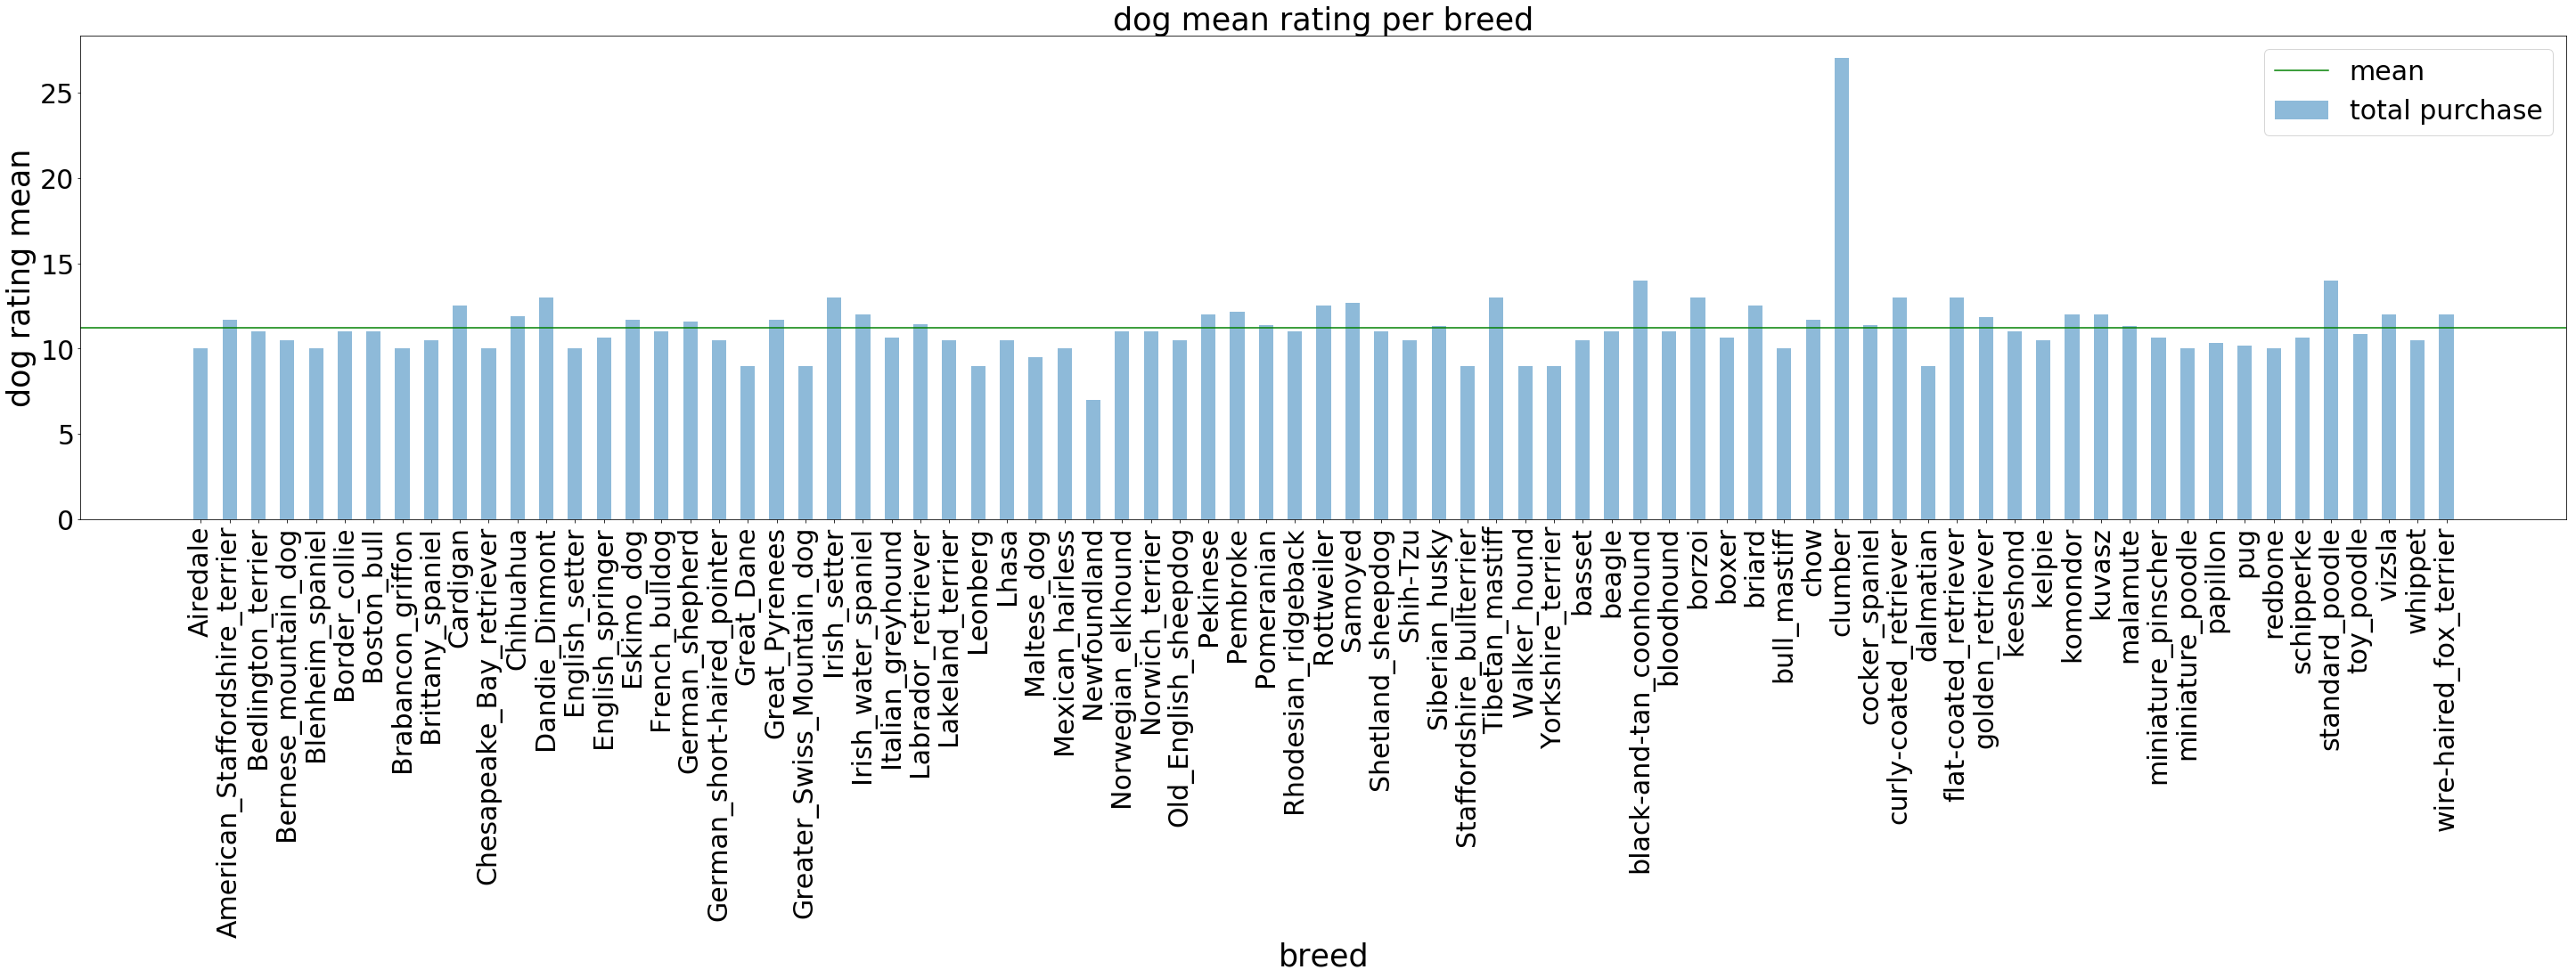

In [58]:
df_by_breed=twitter_archive_master.groupby('breed')
y=list(df_by_breed.rating.mean().values)
x=list(df_by_breed.rating.mean().index)
mean=df_by_breed.rating.mean().values.mean()

fig, ax=plt.subplots(figsize=(50, 10))

ax.bar(x, y, label='total purchase', width=0.5, align='center', alpha=0.5)
ax.axhline(y=mean, label='mean', color='green')
plt.xlabel('breed', fontsize=35)
plt.ylabel('dog rating mean', fontsize=35)
plt.xticks(rotation='vertical', fontsize=30)
plt.yticks(fontsize=30)

plt.title('dog mean rating per breed', fontsize=35)
plt.legend(fontsize=30)

plt.show()

> ### Insight #2
>> The graph visualization #2, shows that Clumber is the breed of dog that has got the highest mean of rating according to the mean of rating per breed and the lowest mean of rating is shown for Newfoundland.The overall mean of rating being ~12

### Visualization #3 : bar plot showing mean rating of dogs per stage

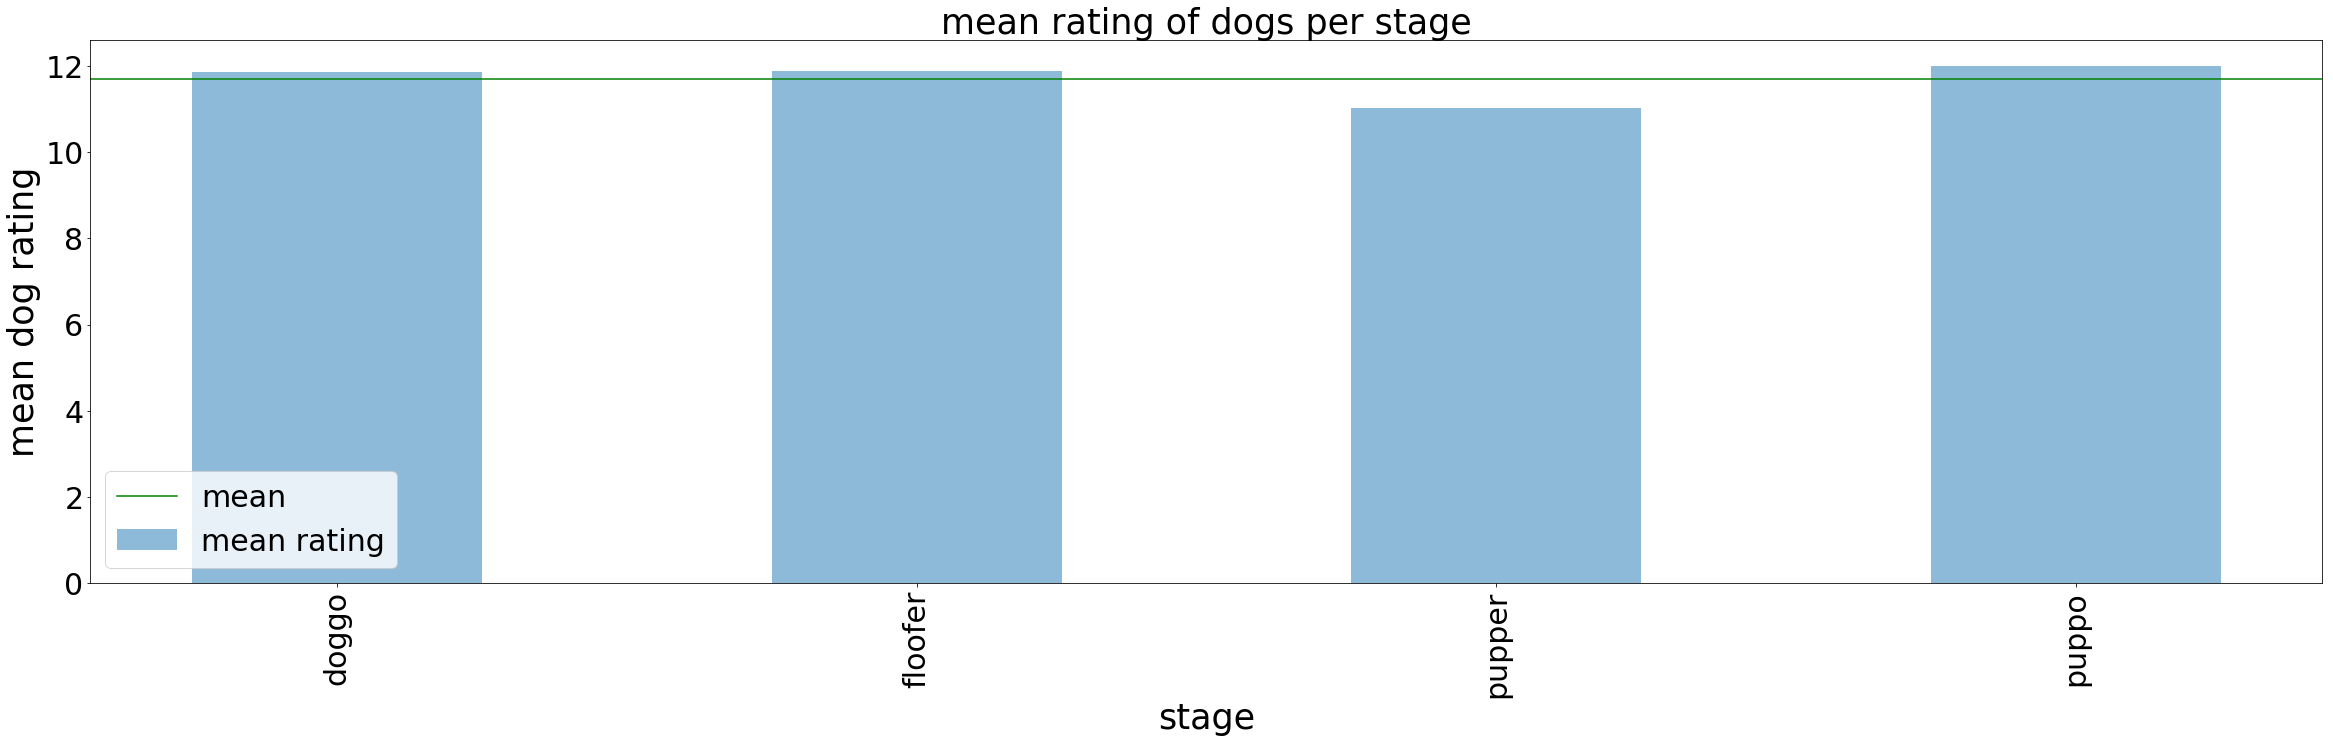

In [59]:
df_by_breed_stage=twitter_archive_master.groupby('stage')
y=list(df_by_breed_stage.rating.mean().values)
x=list(df_by_breed_stage.rating.mean().index)
mean=df_by_breed_stage.rating.mean().values.mean()

fig, ax=plt.subplots(figsize=(40, 10))

ax.bar(x, y, label='mean rating', width=0.5, align='center', alpha=0.5)
ax.axhline(y=mean, label='mean', color='green')
plt.xlabel('stage', fontsize=35)
plt.ylabel('mean dog rating', fontsize=35)
plt.xticks(rotation='vertical', fontsize=30)
plt.yticks(fontsize=30)

plt.title('mean rating of dogs per stage', fontsize=35)
plt.legend(fontsize=30)

plt.show()

> ### Insight #3 :
>> The graph visualization #3 shows that puppo has got the highest rating followed by floofer and doggo and then pupper that has got the lowest rate.

### Visualization #4 : Scatter plot showing the correlation between the number of image and the confidence of the prediction algorithm. 

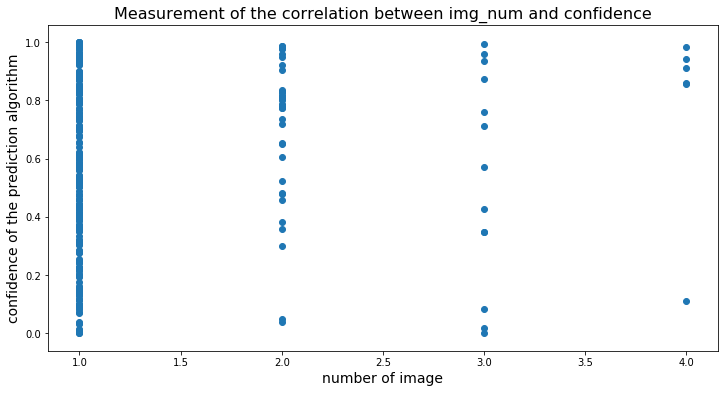

In [60]:
x2=list(twitter_archive_master.img_num)
y2=list(twitter_archive_master.confidence)

plt.figure(figsize=(12,6))
plt.scatter(x2, y2)
plt.xlabel('number of image', fontsize=14)
plt.ylabel('confidence of the prediction algorithm', fontsize=14)
plt.title('Measurement of the correlation between img_num and confidence', fontsize=16)
plt.show()

In [61]:
np.corrcoef(x2, y2)

array([[ 1.       ,  0.1219264],
       [ 0.1219264,  1.       ]])

> ### Insight #4 : 
>> - The graph visualization #4 shows that the img_num and confidence are very weakly correlated and the correlation coefficient 0.12 tells so. Hence the number of images doesn't impact how confident the algorithm is in its prediction.
- The graph tells also that most of the tweets have 1 image